# Real-World Example: Hydrographic Trends in the Baltic Sea

We'll see that in an Ocean model covering the Baltic Sea, there is a long-term trend for the basin- wide hydrography which is overlayed by decadal variability in the deepest parts of the Gotland Basin.

## First, load relevant modules and make sure figures look nice

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("darkgrid")
sns.set_context("talk")

## Then, load the data and crop them to the Baltic Sea

In [4]:
file_name = "data/baltic_hydrography/INSPIRE_1979_2016_annual_oce_surf_and_bottom_hydrograhy.nc"

ds = xr.open_dataset(file_name)

ds = ds.sel(lon=slice(9, None))  # East of 9°E

display(ds)

<xarray.Dataset>
Dimensions:  (lat: 538, lon: 475, time: 38)
Coordinates:
  * lon      (lon) float32 9.0225 9.0675 9.1125 9.1575 9.2025 9.2475 9.2925 ...
  * lat      (lat) float32 53.8225 53.845 53.8675 53.89 53.9125 53.935 ...
  * time     (time) datetime64[ns] 1979-12-31 1980-12-31 1981-12-31 ...
Data variables:
    BTEMP    (time, lat, lon) float32 ...
    SSS      (time, lat, lon) float32 ...
    BSALT    (time, lat, lon) float32 ...
    SST      (time, lat, lon) float32 ...
Attributes:
    history:  Created from monthly INSPIRE fields weighting all months equally.

## Have a first look: Sea-Surface Temperature

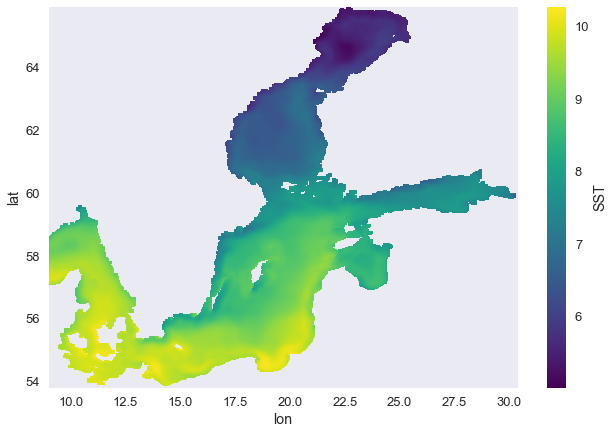

In [5]:
ds.SST.mean("time").plot(size=7);

## Have a second look: Data ranges

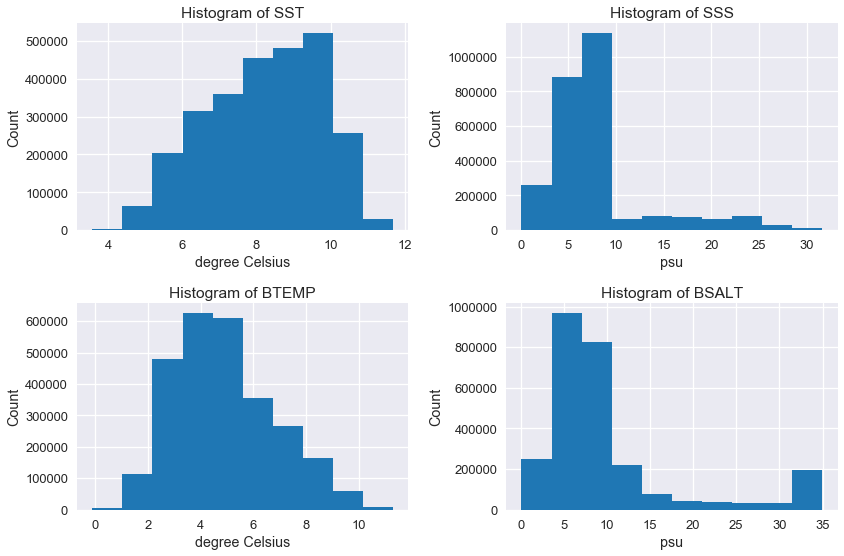

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for _ax, vname in zip(ax.flat, ["SST", "SSS", "BTEMP", "BSALT"]):
    ds[vname].plot.hist(ax=_ax);
    _ax.set_xlabel(ds[vname].units)

fig.tight_layout()

## Calculate and visualize long-term trends

For calculating long-term trends, we'll need a horizontal average that accounts for the size of the grid boxes and a function wrapping a polynomial fit.

In [7]:
def _weighted_horizontal_mean(da):
    lat = da.coords["lat"]
    cos_lat = xr.ufuncs.cos(xr.ufuncs.deg2rad(lat))
    cos_lat = cos_lat + da * 0
    weighted_mean = (cos_lat  * da).sum(dim=["lat", "lon"]) / cos_lat.sum(dim=["lat", "lon"])
    weighted_mean = weighted_mean.rename(da.name)
    return weighted_mean 

def _get_time_in_seconds(time):
    if time.ndim != 0:
        time = (time - time[0]).data
    time = time.astype("timedelta64[s]").astype("float")
    return time

def _get_trend(da):
    time = _get_time_in_seconds(da.coords["time"])
    one_decade = _get_time_in_seconds(np.timedelta64(10, "Y"))
    time /= one_decade
    z = np.polyfit(time, da.data, 1)
    da_trend = 0 * da + np.polyval(z, time)
    slope = z[0] * time[1]
    total_diff = z[0] * time[-1]
    return da_trend, slope, total_diff

Then, we can create and plot the time series we're interested in:

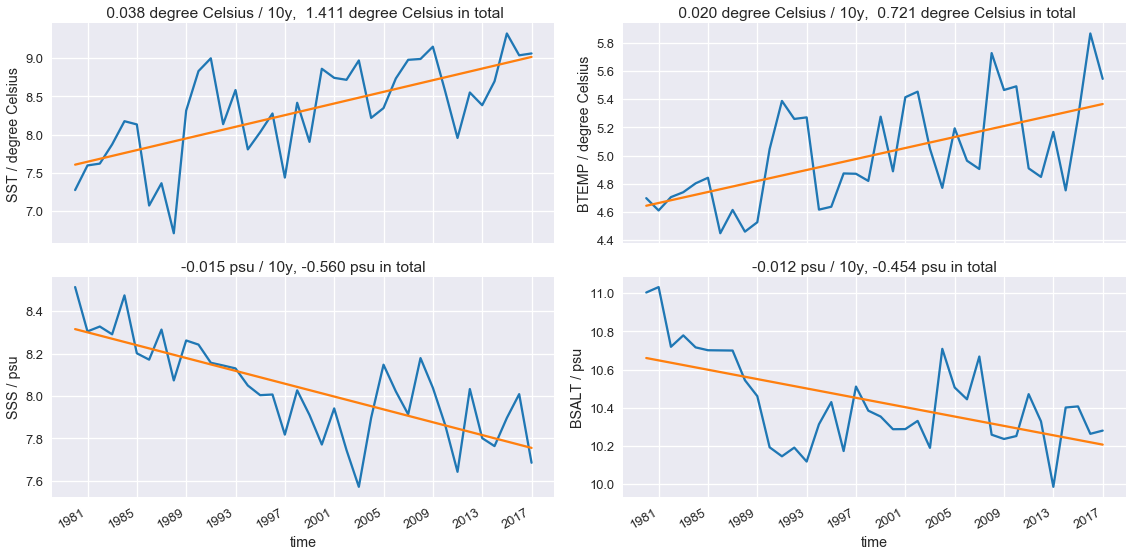

In [8]:
fig, ax_arr = plt.subplots(2, 2, sharex=True, figsize=(16, 8))

for ax, v in zip(ax_arr.flat, [ds[vn] for vn in ["SST", "BTEMP",
                                                 "SSS", "BSALT"]]):

    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=ax);

    v_trend, slope, total_diff = _get_trend(v_mean)
    v_trend.plot(ax=ax);
    
    ax.set_title(("{slope: .3f} {units} / 10y, " +
                  "{total: .3f} {units} in total"
                 ).format(name=v.name, slope=slope, total=total_diff, units=v.units))
    ax.set_ylabel("{} / {}".format(v.name, v.units));

fig.tight_layout();

## Variability in the deep Gotland basin

As our data does not contain any depth-info, we detect the deep layers by exploiting the fact that the amplitude of temperature variations reduces with depth.

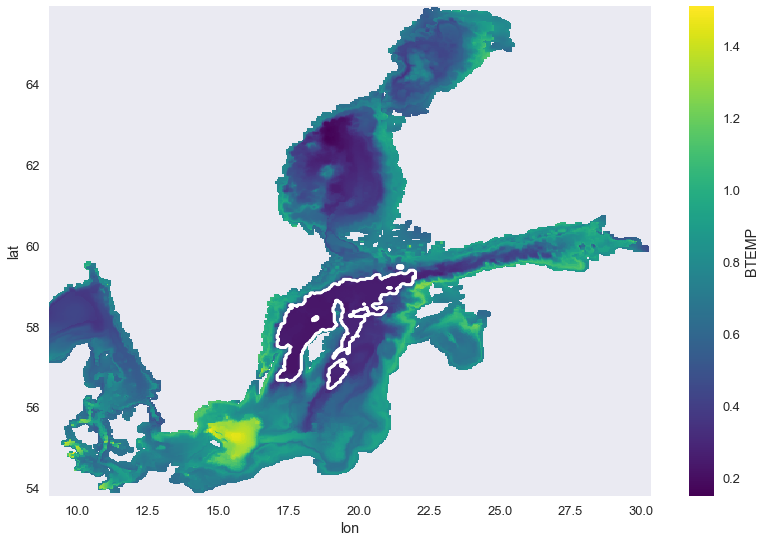

In [9]:
# define boolean mask for deep Gotland basin waters
ds["deep_gotland"] = (
    (ds.BTEMP.std("time") < 0.3) &
    (ds.coords["lat"] < 59.5) & (ds.coords["lon"] < 22.0))
ds.deep_gotland.rename("deep Gotland basin waters")

# plot the mask with temperature variability
ds.BTEMP.std("time").plot(size=9);
ds.deep_gotland.plot.contour(colors=("w", ));

Now that we have a mask for the desired region, we extract bottom temperature and salinity for the region:

In [10]:
ds["BTEMP_DG"] = ds.BTEMP.where(ds.deep_gotland).rename(ds.BTEMP.name + "_DG")
ds["BSALT_DG"] = ds.BSALT.where(ds.deep_gotland).rename(ds.BSALT.name + "_DG")

And we plot the deep-Gotland-basin time series:

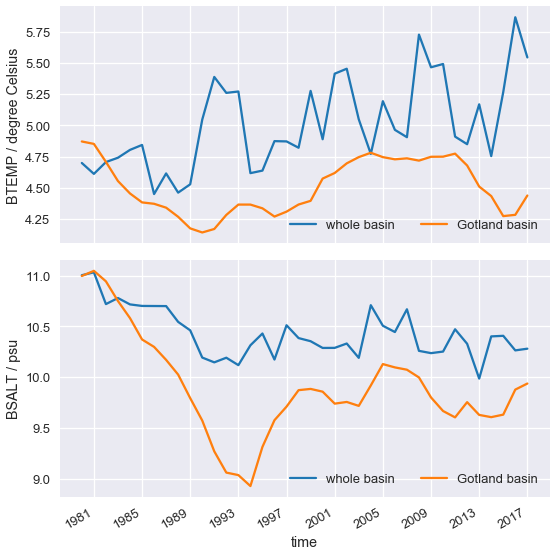

In [11]:
fig, ax_arr = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for ax, v in zip(ax_arr.flat, [ds[vn] for vn in ["BTEMP", "BSALT"]]):
    
    # plot for whole basin
    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=ax, label="whole basin");
    
    # plot for dg only
    v_mean_dg = _weighted_horizontal_mean(ds[v.name + "_DG"])
    v_mean_dg.plot(ax=ax, label="Gotland basin");

    ax.set_ylabel("{} / {}".format(v.name, v.units));
    
    ax.legend(ncol=2, loc=4);

fig.tight_layout();